In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import nibabel as nib
import tqdm
from scipy import ndimage
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(1)

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

<h2> Tratamiento de los datos </h2>

<h3>Carga de los datos y de las rutas de las imagenes</h3>

En primer lugar elaboraremos un dataframe elaborado con Pandas en el que incluiremos las rutas de las imagenes, su identificación, la clase de cancer, su edad, su tipo de operación si es que ha realizado alguna y su supervivencia.
Tambien serán eliminados los campos que no sean importantes como las identificaciones de otros años.


In [3]:
directory_path = 'G:\Dataset'
os.chdir(directory_path)

survival_path = os.path.join(directory_path, 'survival_info.csv')
survival_dataframe = pd.read_csv(survival_path, header=0, index_col='Brats20ID')
survival_dataframe.index.names = ['ID']

grade_dataframe = os.path.join(directory_path, 'name_mapping.csv')
grade_dataframe = pd.read_csv(grade_dataframe, header=0, index_col='BraTS_2020_subject_ID')
grade_dataframe.index.names = ['ID']

In [4]:
dataframe = grade_dataframe.join(survival_dataframe)
dataframe.drop(columns=['BraTS_2017_subject_ID', 'BraTS_2018_subject_ID', 'TCGA_TCIA_subject_ID', 'BraTS_2019_subject_ID'], inplace=True)
dataframe.rename(columns={'Grade':'grade', 'Age':'age','Survival_days':'survival_days','Extent_of_Resection':'extent_of_resection'}, inplace=True)
dataframe.describe(include = 'all')

,grade,age,survival_days,extent_of_resection
count,369,236.000000,236,129
unique,2,NaN,218,2
top,HGG,NaN,448,GTR
freq,293,NaN,3,119
mean,NaN,61.223203,NaN,NaN
std,NaN,11.874114,NaN,NaN
min,NaN,18.975000,NaN,NaN
25%,NaN,54.244250,NaN,NaN
50%,NaN,61.471000,NaN,NaN
75%,NaN,69.200000,NaN,NaN


In [5]:
def load_image_path(dataframe, directory_path):
    '''
    '''
    images=['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii']
    for ID in dataframe.index:
        dataframe.at[ID, 't1'] = os.path.join(directory_path, ID, ID+images[0])
        dataframe.at[ID, 't1ce'] = os.path.join(directory_path, ID, ID+images[1])
        dataframe.at[ID, 't2'] = os.path.join(directory_path, ID, ID+images[2])
        dataframe.at[ID, 'flair'] = os.path.join(directory_path, ID, ID+images[3])
    return dataframe

In [6]:
dataframe = load_image_path(dataframe, directory_path)
dataframe.head()

,grade,age,survival_days,extent_of_resection,t1,t1ce,t2,flair
ID,,,,,,,,
BraTS20_Training_001,HGG,60.463,289,GTR,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...
BraTS20_Training_002,HGG,52.263,616,GTR,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...
BraTS20_Training_003,HGG,54.301,464,GTR,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...
BraTS20_Training_004,HGG,39.068,788,GTR,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...
BraTS20_Training_005,HGG,68.493,465,GTR,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...


<h3>Preprocesado de los datos</h3>

In [7]:
#Analizando los datos podemos observar que todos los pacientes con un grado de tumor bajo no tienen datos de supervivencia ni de
#extracción del tumor, ni edad. Esto es en gran medida porque estos pacientes tienen un pronostico bastante favorable [1] y la mayoria no necesita cirugia.
#Por eso asumiremos que ninguno de ellos se realizo cirugía, su edad será fijada de forma aleatoria entre el minimo y el maximo de las edades y el tiempo de supervivencia sera aleatorio entre 
#https://www.analesdepediatria.org/es-gliomas-bajo-grado-revision-10-articulo-S1695403314000873#:~:text=La%20supervivencia%20global%20fue%20del%2088%2C3%25%2C%20con%20una,fue%20del%2083%2C7%25.
#https://ascopubs.org/doi/full/10.1200/JOP.2016.018622#:~:text=A%20larger%20study%20of%20216,of%20resection%20was%20%3C%2090%25.

#Segun el estudio [2] un 76% de las personas con una extirpación de menos del 90% del tumor sobrevivieron más de 5 años. Por lo que
#como asumimos que estas personas no se realizaron cirugía ya que no tenemos datos, calcularemos el tiempo de supervivencia como un número
#aleatorio entre 4 y 7 teniendo un 24% de ser entre 4-5 y un 76% de ser entre 5-7
#En cuanto a la edad esta será calcula aleatoriamente en el rango de la media del resto de las edades con la desviacion tipica [media-dt, media+dt] 
dataframe.loc[(dataframe['grade'] != 'HGG') & (pd.isna(dataframe['age']) == True)].head(5)

,grade,age,survival_days,extent_of_resection,t1,t1ce,t2,flair
ID,,,,,,,,
BraTS20_Training_260,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...
BraTS20_Training_261,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...
BraTS20_Training_262,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...
BraTS20_Training_263,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...
BraTS20_Training_264,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...


In [8]:
def generate_survival(dataframe):
    '''
    '''
    a=4
    b=5
    c=7
    probability_low = 24
    indexes = dataframe.loc[(pd.isna(dataframe['age']) == True)].index
    survival_fill = pd.DataFrame([0 for i in range(0, len(indexes))], columns=['fill'], index=indexes)
    for i in indexes.values:
        low = np.random.randint((a*365), high=(b*365)+1)
        high = np.random.randint((b*365), high=(c*365)+1)
        probability = np.random.randint(1, high=101)
        
        if probability <= probability_low:
            survival_fill.loc[i, 'fill'] = low
        else:
            survival_fill.loc[i, 'fill'] = high
            
    return survival_fill['fill']

def generate_age(dataframe):
    '''
    '''
    indexes = dataframe.loc[(pd.isna(dataframe['age']) == True)].index
    age_fill = pd.DataFrame([0 for i in range(0, len(indexes))], columns=['fill'], index=indexes)
    
    ages = dataframe.loc[pd.isna(dataframe['age']) == False]
    age_mean = np.round(ages.mean(), 3)
    age_std = np.round(ages.std(), 3)
    minimo = age_mean-age_std
    maximo = age_mean+age_std
    
    for i in indexes.values:
        random = np.round(np.random.uniform(minimo, maximo), 3)
        age_fill.loc[i, 'fill'] = random
        
    return age_fill['fill']

def normalize_age(dataframe):
    '''
    '''
    max_value = dataframe['age'].max()
    min_value = dataframe['age'].min()
    dataframe['age'] = (dataframe['age'] - min_value) / (max_value - min_value)
    return dataframe

In [9]:
dataframe['survival_days'].fillna(generate_survival(dataframe), inplace=True)
dataframe['age'].fillna(generate_age(dataframe), inplace=True)
#dataframe = normalize_age(dataframe)

grade_encoding = {'LGG':0, 'HGG':1}
dataframe['grade'] = dataframe['grade'].replace(grade_encoding)

dataframe.drop(dataframe.loc[dataframe['survival_days'] == 'ALIVE (361 days later)'].index, axis=0, inplace=True)
dataframe = dataframe.astype({"grade": int, 'survival_days':int})

survival_encoding = {'Short survivor':0, 'Mid survivor':1, 'Long survivor':2}
for i in dataframe.index:
    if dataframe['survival_days'].loc[i] < 365:
        dataframe.loc[[i],['survival_days']] = survival_encoding['Short survivor']
    elif dataframe['survival_days'].loc[i] < 1825:
        dataframe.loc[[i],['survival_days']] = survival_encoding['Mid survivor']
    else:
        dataframe.loc[[i],['survival_days']] = survival_encoding['Long survivor']
        
dataframe['extent_of_resection'].fillna('NONE', inplace=True)
dataframe = pd.get_dummies(dataframe, columns=['extent_of_resection'], prefix='resection_')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15752\3122688624.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  age_mean = np.round(ages.mean(), 3)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15752\3122688624.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  age_std = np.round(ages.std(), 3)


In [10]:
dataframe.head()

,grade,age,survival_days,t1,t1ce,t2,flair,resection__GTR,resection__NONE,resection__STR
ID,,,,,,,,,,
BraTS20_Training_001,1,60.463,0,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,1,0,0
BraTS20_Training_002,1,52.263,1,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,1,0,0
BraTS20_Training_003,1,54.301,1,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,1,0,0
BraTS20_Training_004,1,39.068,1,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,1,0,0
BraTS20_Training_005,1,68.493,1,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,1,0,0


In [11]:
diff = dataframe.loc[dataframe['grade'] == 1].count()[0] - dataframe.loc[dataframe['grade'] == 0].count()[0]

In [12]:
for i in range(diff):
    dataframe.drop(dataframe.loc[dataframe['grade'] == 1].index[-1], inplace=True)

<h3>Carga y preprocesado de las imagenes</h3>

In [13]:
def read_scan(filepath):
    """Read and load volume"""
    # Read file
    img = nib.load(filepath)
    # Rotate the image to a fixed axes
    img = nib.as_closest_canonical(img)
    # Get raw data
    img = img.get_fdata()
    return img

def normalize(img):
    """Normalize the volume"""
    minimun = np.amin(img)
    maximun = np.amax(img)
    img = (img - minimun) / (maximun - minimun)
    img = img.astype("float32")
    return img[:,:,-90::30]

def resize_volume(img):
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / self.depth
    width = current_width / self.width
    height = current_height / self.height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img        

def preproces_images(dataframe):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    print("---preprocesando imágenes---")
    dataframe["t1p"] = None
    dataframe["t1cep"] = None
    dataframe["t2p"] = None
    dataframe["flairp"] = None

    indexes = dataframe.index
    for num, row in enumerate(dataframe.itertuples()):
        img = read_scan(row.t1)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(img.shape)
        path = row.t1.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 't1p'] = path

        img = read_scan(row.t1ce)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(num)
        path = row.t1ce.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 't1cep'] = path

        img = read_scan(row.t2)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(num)
        path = row.t2.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 't2p'] = path

        img = read_scan(row.flair)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(num)
        path = row.flair.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 'flairp'] = path
    print("---preprocesado finalizado---")
    return dataframe

def get_paths(dataframe):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    print("---guardando rutas---")
    dataframe["t1p"] = None
    dataframe["t1cep"] = None
    dataframe["t2p"] = None
    dataframe["flairp"] = None
    indexes = dataframe.index
    
    for num, row in enumerate(dataframe.itertuples()):
        path = row.t1.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 't1p'] = path

        path = row.t1ce.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 't1cep'] = path

        path = row.t2.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 't2p'] = path

        path = row.flair.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 'flairp'] = path
    print("---rutas guardadas---")
    return dataframe

In [14]:
#dataframe = preproces_images(dataframe)
dataframe = get_paths(dataframe)

---guardando rutas---
---rutas guardadas---


In [15]:
# def generate_data(indexes, dataframe, output):
#     """
#     Used to generate a batch with images when training/testing/validating our Keras model.
#     """
#     dataframe_2 = dataframe.iloc[indexes]
#     # arrays to store our batched data
#     X, y = [], []
#     aux = np.zeros(shape=(1,4)).astype('float32')
#     for row in dataframe_2.itertuples():

#         t1_path = row.t1p
#         t1ce_path = row.t1cep
#         t2_path = row.t2p
#         flair_path = row.flairp

#         for i in range(4):
#             if(i == 0):
#                 img = np.load(t1_path)
#             elif(i == 1):
#                 img = np.load(t1ce_path)
#             elif(i == 2):
#                 img = np.load(t2_path)
#             elif(i == 3):
#                 img = np.load(flair_path)

#             if(output == 'grade'):
#                 aux[0, 0] = row.age
#                 aux[0, 1] = row.resection__GTR
#                 aux[0, 2] = row.resection__NONE
#                 aux[0, 3] = row.resection__STR

#                 y.append(np.array(to_categorical(row.grade, 2)).astype('float32'))
#                 X.append([img, aux])
#             else:
#                 aux[0, 0] = row.age*100
#                 aux[0, 1] = row.resection__GTR*100
#                 aux[0, 2] = row.resection__NONE*100
#                 aux[0, 3] = row.resection__STR*100
#                 y.append(np.array(to_categorical(row.survival, 3)).astype('float32'))
#                 X.append([img, aux])

#     return np.array(X), np.array(y)

# X_grade_train, y_grade_train = generate_data(train_index, dataframe, 'grade')
# X_grade_valid, y_grade_valid = generate_data(valid_inex, dataframe, 'grade')
# X_grade_test, y_grade_test = generate_data(test_index, dataframe, 'grade')
# X_survival_train, y_survival_train = generate_data(train_index, dataframe, 'survival')
# X_survival_valid, y_survival_valid = generate_data(valid_inex, dataframe, 'survival')
# X_survival_test, y_survival_test = generate_data(test_index, dataframe, 'survival')

In [16]:
class Data_generator():
    """
    Data generator
    """
    def __init__(self, dataframe, train_size, width, height, depth):
        self.dataframe = dataframe
        self.train_size = train_size
        self.slices = slices
        self.width = width
        self.height = height
        self.depth = depth
        
    def generate_split_indexes(self):
        '''
        '''
        np.random.seed(1)
        permutation = np.random.permutation(len(self.dataframe))
        index = int(len(self.dataframe) * self.train_size)
        train_index = permutation[:index]
        test_index = permutation[index:]
        
        index = int(index * self.train_size)
        train_index, valid_index = train_index[:index], train_index[index:]
        
        return train_index, valid_index, test_index
    
    
    def generate_data(self, indexes, is_training, output, batch_size=32):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        dataframe = self.dataframe.iloc[indexes]
        # arrays to store our batched data
        images, text, labels = [], [], []
        while True:
            for row in dataframe.itertuples():
                
                t1_path = row.t1p
                t1ce_path = row.t1cep
                t2_path = row.t2p
                flair_path = row.flairp
                for i in range(4):
                    if(i == 0):
                        img = np.load(t1_path)
                    elif(i == 1):
                        img = np.load(t1ce_path)
                    elif(i == 2):
                        img = np.load(t2_path)
                    elif(i == 3):
                        img = np.load(flair_path)
                    images.append(img)
                    
                    if(output == 'grade'):
                        labels.append(to_categorical(row.grade, 2))
                        text.append([row.age, row.resection__GTR, row.resection__NONE, row.resection__STR])
                    else:
                        labels.append(to_categorical(row.survival_days, 3))
                        text.append([row.age*10, row.resection__GTR*10, row.resection__NONE*10, row.resection__STR*10])
                    

                    # Lo que hace yield es crear un generador, es decir, cuando se ejecute este trozo de código no se ejecuta
                    # instantaneamente, sino que más adelante cuando internamente el programa llame a next se ejecutará el código
                    # hasta que se encuentre un yield y ahí parará. Con el siguiente next volvera a hacer una iteración y así.
                    if len(images) >= batch_size:
                        yield [np.float32(images), np.float32(text)], np.float32(labels)
                        images, text, labels = [], [], []
                    
            if not is_training:
                break

In [17]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2,figsize=(16,4))
    
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Precisión del modelo')
    axs[0].set(xlabel='Epoch', ylabel='Precisión')
    axs[0].legend(['Entrenamiento', 'Validación'], loc='upper left')
    
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Perdida del modelo')
    axs[1].set(xlabel='Epoch', ylabel='Perdida')
    axs[1].legend(['Entrenamiento', 'Validación'], loc='upper left')
    
    plt.show()

In [18]:
def plot_results(true, pred, encoding):
    pred = np.argmax(pred, axis=1)
    cr_survival = classification_report(true, pred, target_names=encoding.keys())
    print(cr_survival)

In [19]:
def plot_confusion(true, pred, encoding):
    pred = np.argmax(pred, axis=1)
    cf_matrix = confusion_matrix(true, pred)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

    ax.set_title('Matriz de confusión\n\n');
    ax.set_xlabel('\nValores predichos')
    ax.set_ylabel('Valores reales ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(encoding.keys(),)
    ax.yaxis.set_ticklabels(encoding.keys(),)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [20]:
train_size = 0.80
image_width = 240
image_height = 240
slices = 3

data_generator = Data_generator(dataframe, train_size, image_width, image_height, slices)
train_index, valid_index, test_index = data_generator.generate_split_indexes() 

## DenseNet121 batch-batch

In [21]:
def crear_rama_grado(modelo, input_text):
    """
    crea la rama que predice el grado del tumor
    """
    rama_grado = layers.Concatenate()([modelo, input_text])

    rama_grado = layers.Dense(256, activation="relu")(rama_grado)
    rama_grado = layers.BatchNormalization()(rama_grado)
    rama_grado = layers.Dropout(0.3)(rama_grado)
    rama_grado = layers.Dense(256, activation="relu")(rama_grado)
    rama_grado = layers.Dense(2)(rama_grado)
    rama_grado = layers.Activation("softmax", name="grade")(rama_grado)

    return rama_grado

def crear_rama_supervivencia(modelo, input_text):
    """
    crea la rama que predice la supervivencia del paciente
    """
    rama_supervivencia = layers.Concatenate()([modelo, input_text])

    rama_supervivencia = layers.Dense(32, activation="relu")(rama_supervivencia)
    rama_supervivencia = layers.Dropout(0.2)(rama_supervivencia)
    rama_supervivencia = layers.Dense(64, activation="relu")(rama_supervivencia)
    rama_supervivencia = layers.Dense(3)(rama_supervivencia)
    rama_supervivencia = layers.Activation("softmax", name="survival")(rama_supervivencia)

    return rama_supervivencia

In [22]:
from tensorflow.keras.applications.densenet import DenseNet121
input_text = layers.Input(shape=(4,))

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0005), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0005), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [23]:
train_df = dataframe.iloc[train_index]
g0 = train_df.loc[train_df.grade == 0].count()[0]
g1 = train_df.loc[train_df.grade == 1].count()[0]
gt = g0 + g1
s0 = train_df.loc[train_df.survival_days == 0].count()[0]
s1 = train_df.loc[train_df.survival_days == 1].count()[0]
s2 = train_df.loc[train_df.survival_days == 2].count()[0]
st = s0 + s1 + s2

grade_weight = {
    0: (gt/(2*g0)),
    1: (gt/(2*g1)),
}

survival_weight = {
    0: (st/(2*s0)),
    1: (st/(2*s0)),
    2: (st/(2*s0)),
}

In [24]:
epochs = 75
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1,
                    class_weight=survival_weight)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/75
24/24 [==============================] - 25s 354ms/step - loss: 17.3878 - accuracy: 0.3620 - recall_1: 0.3620 - val_loss: 5.9376 - val_accuracy: 0.4583 - val_recall_1: 0.4583
Epoch 2/75
24/24 [==============================] - 12s 495ms/step - loss: 10.0436 - accuracy: 0.4948 - recall_1: 0.4922 - val_loss: 3.1891 - val_accuracy: 0.4271 - val_recall_1: 0.4167
Epoch 3/75
24/24 [==============================] - 8s 322ms/step - loss: 8.3672 - accuracy: 0.4297 - recall_1: 0.4271 - val_loss: 3.6799 - val_accuracy: 0.3021 - val_recall_1: 0.3021
Epoch 4/75
24/24 [==============================] - 6s 257ms/step - loss: 6.2977 - accuracy: 0.4609 - recall_1: 0.4531 - val_loss: 1.3695 - val_accuracy: 0.4792 - val_recall_1: 0.4375
Epoch 5/75
24/24 [==============================] - 7s 317ms/step - loss: 4.8748 - accuracy: 0.5417 - recall_1: 0.5312 - val_loss: 1.0184 - val_accurac

Epoch 45/75
24/24 [==============================] - 8s 351ms/step - loss: 0.0247 - accuracy: 0.9974 - recall_1: 0.9974 - val_loss: 1.4085 - val_accuracy: 0.6354 - val_recall_1: 0.6250
Epoch 46/75
24/24 [==============================] - 8s 333ms/step - loss: 0.0475 - accuracy: 0.9974 - recall_1: 0.9974 - val_loss: 1.3731 - val_accuracy: 0.6562 - val_recall_1: 0.6354
Epoch 47/75
24/24 [==============================] - 7s 311ms/step - loss: 0.0356 - accuracy: 0.9948 - recall_1: 0.9948 - val_loss: 1.4275 - val_accuracy: 0.6354 - val_recall_1: 0.6042
Epoch 48/75
24/24 [==============================] - 8s 357ms/step - loss: 0.0286 - accuracy: 0.9974 - recall_1: 0.9974 - val_loss: 1.4412 - val_accuracy: 0.6354 - val_recall_1: 0.6042
Epoch 49/75
24/24 [==============================] - 7s 304ms/step - loss: 0.0427 - accuracy: 0.9948 - recall_1: 0.9948 - val_loss: 1.3891 - val_accuracy: 0.6667 - val_recall_1: 0.6458
Epoch 50/75
24/24 [==============================] - 7s 297ms/step - loss: 

In [25]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1,
                    class_weight=grade_weight)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/75
24/24 [==============================] - 24s 512ms/step - loss: 0.4977 - accuracy: 0.7682 - recall: 0.7682 - val_loss: 3.1820 - val_accuracy: 0.5000 - val_recall: 0.5000
Epoch 2/75
24/24 [==============================] - 9s 353ms/step - loss: 0.4111 - accuracy: 0.8516 - recall: 0.8516 - val_loss: 2.6237 - val_accuracy: 0.5104 - val_recall: 0.5104
Epoch 3/75
24/24 [==============================] - 8s 336ms/step - loss: 0.2476 - accuracy: 0.9141 - recall: 0.9141 - val_loss: 1.0059 - val_accuracy: 0.5625 - val_recall: 0.5625
Epoch 4/75
24/24 [==============================] - 9s 383ms/step - loss: 0.1997 - accuracy: 0.9375 - recall: 0.9375 - val_loss: 0.5789 - val_accuracy: 0.7500 - val_recall: 0.7500
Epoch 5/75
24/24 [==============================] - 8s 318ms/step - loss: 0.1585 - accuracy: 0.9427 - recall: 0.9427 - val_loss: 2.1838 - val_accuracy: 0.5104 - val_recall: 0.510

In [26]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

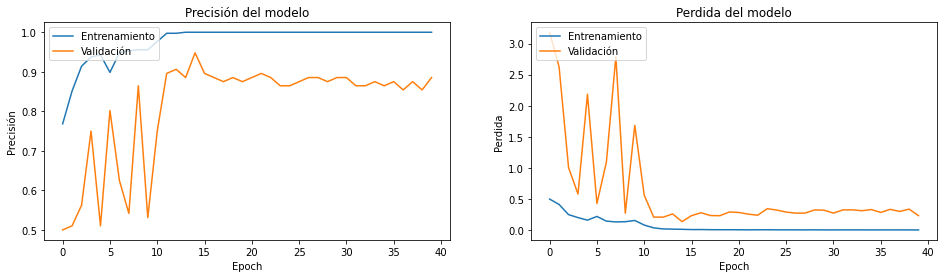

In [27]:
plot_history(grade_history)

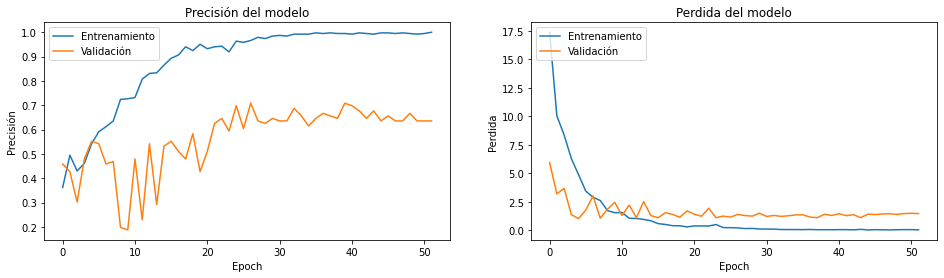

In [28]:
plot_history(survival_history)

In [29]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [30]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [31]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.96      0.93      0.95        56
         HGG       0.94      0.97      0.96        68

    accuracy                           0.95       124
   macro avg       0.95      0.95      0.95       124
weighted avg       0.95      0.95      0.95       124



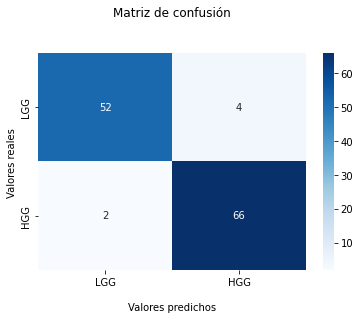

In [32]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [33]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.43      0.25      0.32        36
  Mid survivor       0.45      0.30      0.36        56
 Long survivor       0.49      1.00      0.66        32

      accuracy                           0.47       124
     macro avg       0.46      0.52      0.45       124
  weighted avg       0.45      0.47      0.43       124



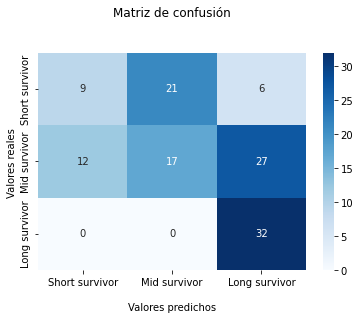

In [34]:
plot_confusion(survival_true, survival_pred, survival_encoding)